In [6]:
import gc
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd
import os

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import NullFormatter
%matplotlib inline

plt.style.use('ggplot') #ggplot스타일 사용
rcParams['figure.figsize'] = (16, 8)
plt.rc('axes', unicode_minus=False)
pd.set_option('max_columns', 100)

In [3]:
df = pd.read_csv('santander-value-prediction-challenge/train.csv')

In [8]:
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,...,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


# Data preprocessing
- train, test sample data load
- 중복 변수 제거
- train, test 하나의 데이터로 병합

In [10]:
SAMPLE_SIZE = 4459

# Read train and test files
train_df = pd.read_csv('santander-value-prediction-challenge/train.csv').sample(SAMPLE_SIZE)
test_df = pd.read_csv('santander-value-prediction-challenge/test.csv').sample(SAMPLE_SIZE)

# Get the combined data
total_df = pd.concat([train_df.drop('target', axis=1), test_df], axis=0).drop('ID', axis=1)

# Columns to drop because there is no variation in training set
# train, test 병합
zero_std_cols = train_df.drop("ID", axis=1).columns[train_df.std() == 0]
total_df.drop(zero_std_cols, axis=1, inplace=True)
print(f">> Removed {len(zero_std_cols)} constant columns")

# Removing duplicate columns
# Taken from: https://www.kaggle.com/scirpus/santander-poor-mans-tsne
colsToRemove = []
colsScaned = []
dupList = {}
columns = total_df.columns
for i in range(len(columns)-1):
    v = train_df[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, train_df[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
colsToRemove = list(set(colsToRemove))
total_df.drop(colsToRemove, axis=1, inplace=True)
print(f">> Dropped {len(colsToRemove)} duplicate columns")

# Go through the columns one at a time (can't do it all at once for this dataset)
total_df_all = deepcopy(total_df)              
for col in total_df.columns:
    
    # 3 * 표준편차를 통해서 데이터 99% 밖에 있는 이상치를 제거
    data = total_df[col].values
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
    if len(outliers) > 0:
        non_zero_idx = data != 0
        total_df.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
    
    # Scale non-zero column values
    nonzero_rows = total_df[col] != 0
    total_df.loc[nonzero_rows, col] = scale(total_df.loc[nonzero_rows, col])
    
    # Scale all column values
    total_df_all[col] = scale(total_df_all[col])
    gc.collect()
    
# 후에 train, test 분할하는 과정에서 필요한 인덱스 저장
train_idx = range(0, len(train_df))
test_idx = range(len(train_df), len(total_df))


>> Removed 256 constant columns
>> Dropped 5 duplicate columns


In [11]:
total_df_all.shape

(8918, 4730)

# PCA perform

In [12]:
# pca 함수
def test_pca(data, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    # Create a PCA object, specifying how many components we wish to keep
    # 주성분의 갯수는 1000개
    pca = PCA(n_components=1000)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(data)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=total_df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        # Create two plots next to each other
        _, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 4):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[train_idx].plot(label='Train', c='#ff7f0e', **settings)
            pca_df.iloc[test_idx].plot(label='Test',  c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca_df


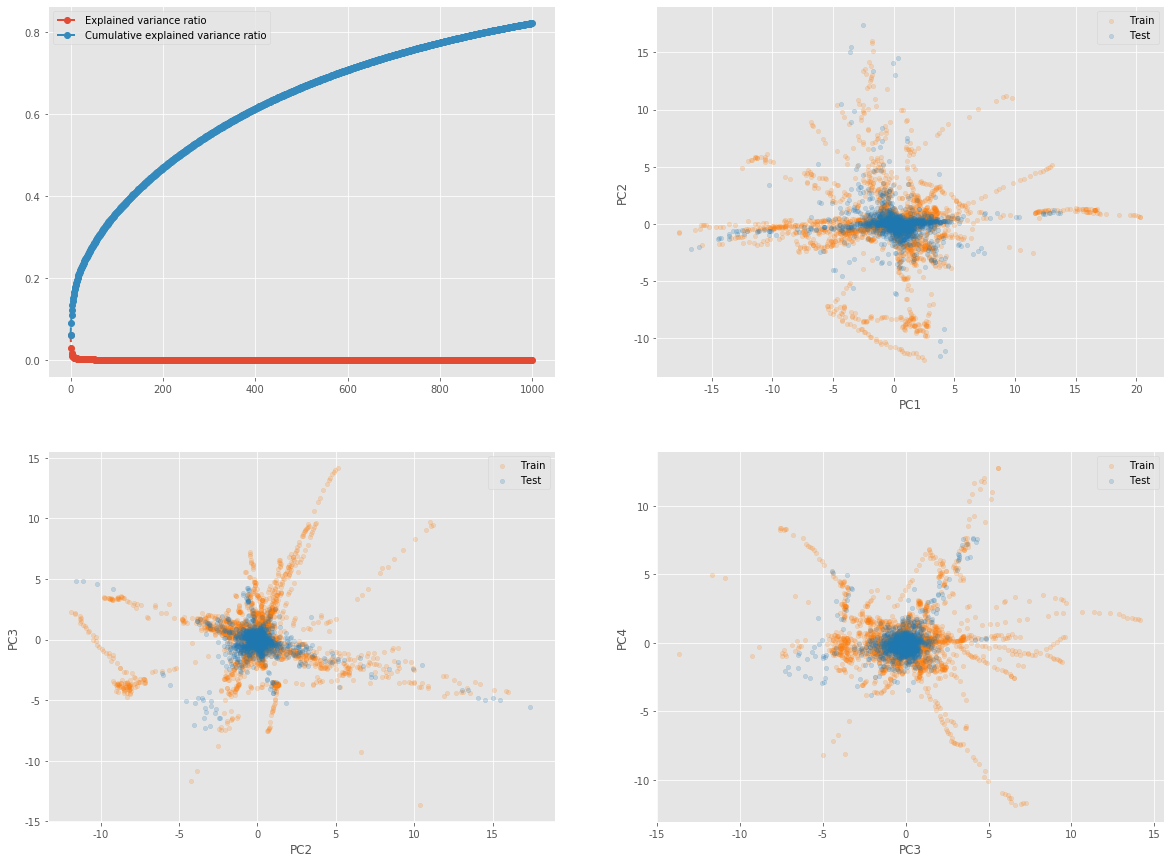

In [13]:
# 각 주성분별로 좌표에 뿌려져 있는 분포 확인
# Run the PCA and get the embedded dimension
pca_df = test_pca(total_df)
pca_df_all = test_pca(total_df_all, create_plots=False)

# T-sne

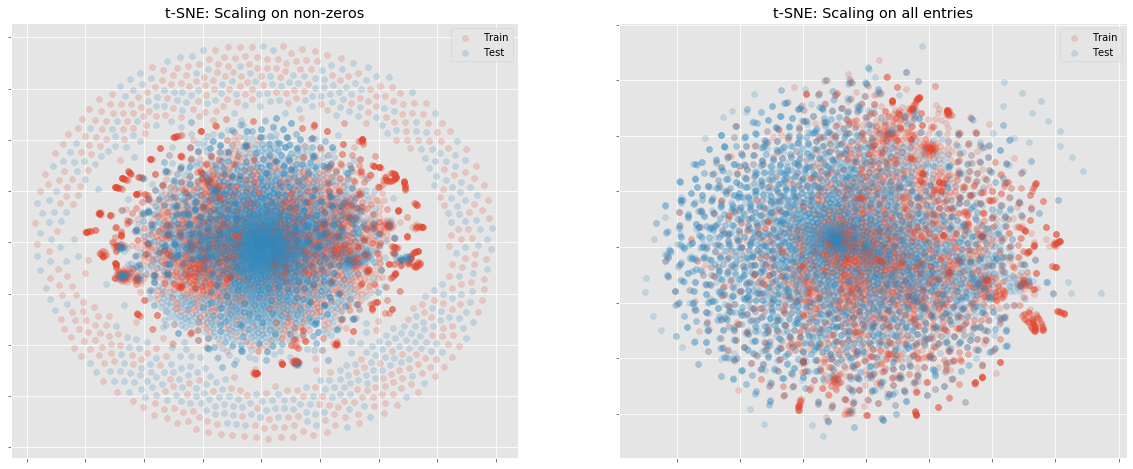

In [14]:
def test_tsne(data, ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""

    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca')
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return Y

# Run t-SNE on PCA embedding
# PCA 차원에 임베딩된 데이터를 활용한 t-sne수행
_, axes = plt.subplots(1, 2, figsize=(20, 8))

tsne_df = test_tsne(
    pca_df, axes[0],
    title='t-SNE: Scaling on non-zeros'
)
tsne_df_unique = test_tsne(
    pca_df_all, axes[1],
    title='t-SNE: Scaling on all entries'
)

plt.axis('tight')
plt.show()  

In [15]:

def test_prediction(data):
    """Try to classify train/test samples from total dataframe"""

    # Create a target which is 1 for training rows, 0 for test rows
    y = np.zeros(len(data))
    y[train_idx] = 1

    # Perform shuffled CV predictions of train/test label
    predictions = cross_val_predict(
        ExtraTreesClassifier(n_estimators=100, n_jobs=4),
        data, y,
        cv=StratifiedKFold(
            n_splits=10,
            shuffle=True,
            random_state=42
        )
    )

    # Show the classification report
    print(classification_report(y, predictions))
    
# Run classification on total raw data
test_prediction(total_df_all)

              precision    recall  f1-score   support

         0.0       0.88      0.52      0.65      4459
         1.0       0.66      0.93      0.77      4459

    accuracy                           0.72      8918
   macro avg       0.77      0.72      0.71      8918
weighted avg       0.77      0.72      0.71      8918



100%|██████████| 4730/4730 [00:08<00:00, 534.46it/s]


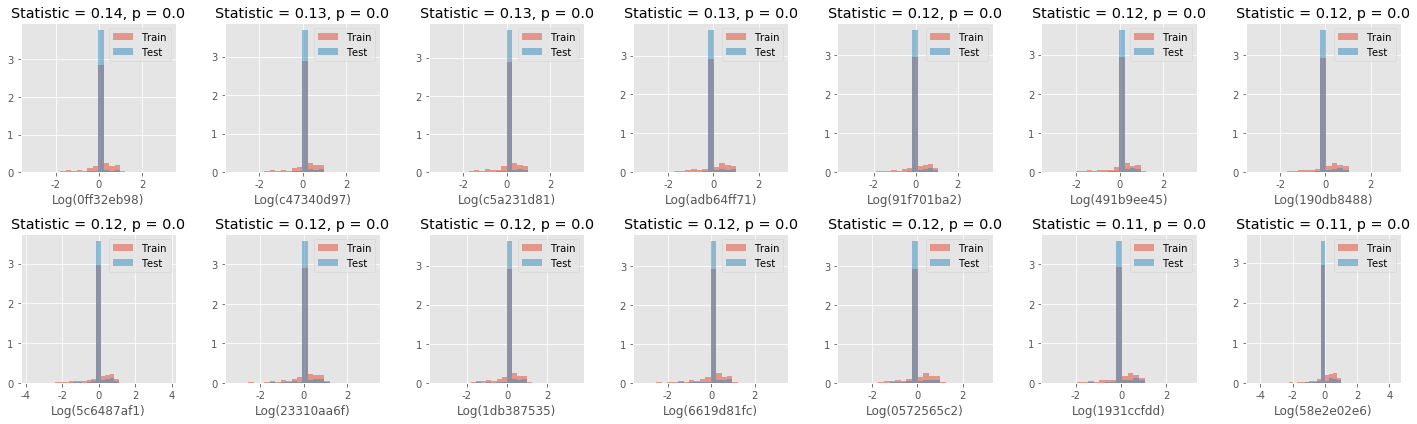

In [16]:
def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue <= 0.05 and np.abs(statistic) > threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)

    if show_plots:
        # Let us see the distributions of these columns to confirm they are indeed different
        n_cols = 7
        if show_all:
            n_rows = int(len(diff_df) / 7)
        else:
            n_rows = 2
        _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
        axes = [x for l in axes for x in l]

        # Create plots
        for i, (_, row) in enumerate(diff_df.iterrows()):
            if i >= len(axes):
                break
            extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
            train_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Train', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            test_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Test', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            axes[i].set_title(f"Statistic = {row.statistic}, p = {row.p}")
            axes[i].set_xlabel(f'Log({row.feature})')
            axes[i].legend()

        plt.tight_layout()
        plt.show()
        
    return diff_df

# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(total_df.iloc[train_idx], total_df.iloc[test_idx])

In [17]:
# 통계분석을(유의확률 비교) 통해 분포가 다르다고 도출되는 변수들을 제거했을 때
print(f">> Dropping {len(diff_df)} features based on KS tests")
test_prediction(
    total_df.drop(diff_df.feature.values, axis=1)
)

>> Dropping 25 features based on KS tests
              precision    recall  f1-score   support

         0.0       0.84      0.44      0.58      4459
         1.0       0.62      0.92      0.74      4459

    accuracy                           0.68      8918
   macro avg       0.73      0.68      0.66      8918
weighted avg       0.73      0.68      0.66      8918



# decomposition

>> Ran TruncatedSVD
>> Ran PCA
>> Ran FastICA
>> Ran GaussianRandomProjection
>> Ran SparseRandomProjection


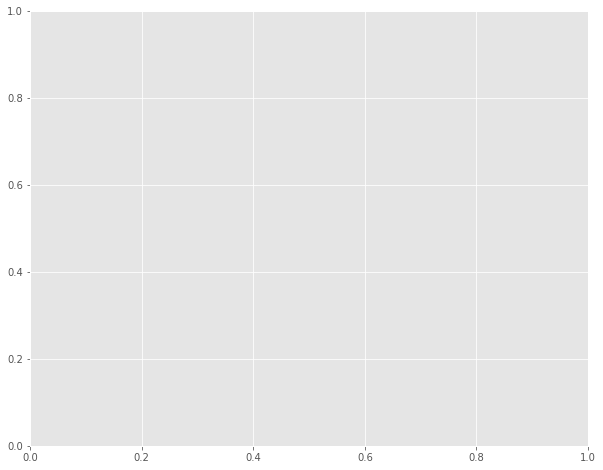

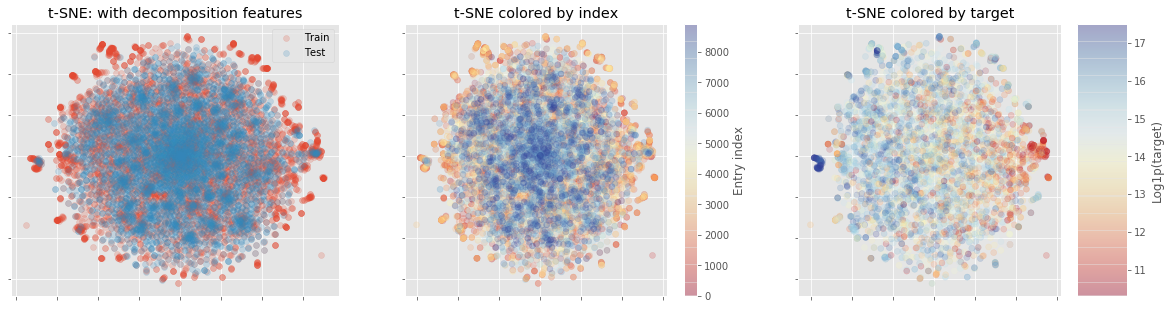

In [21]:
COMPONENTS = 20
cm = plt.cm.get_cmap('RdYlBu')
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
# List of decomposition methods to use
methods = [
    TruncatedSVD(n_components=COMPONENTS),
    PCA(n_components=COMPONENTS),
    FastICA(n_components=COMPONENTS),
    GaussianRandomProjection(n_components=COMPONENTS, eps=0.1),
    SparseRandomProjection(n_components=COMPONENTS, dense_output=True)    
]

# Run all the methods
embeddings = []
for method in methods:
    name = method.__class__.__name__    
    embeddings.append(
        pd.DataFrame(method.fit_transform(total_df), columns=[f"{name}_{i}" for i in range(COMPONENTS)])
    )
    print(f">> Ran {name}")
    
# Put all components into one dataframe
components_df = pd.concat(embeddings, axis=1)

# Prepare plot
_, axes = plt.subplots(1, 3, figsize=(20, 5))

# Run t-SNE on components
tsne_df = test_tsne(
    components_df, axes[0],
    title='t-SNE: with decomposition features'
)

# Color by index
sc = axes[1].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=range(len(tsne_df)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('Entry index')
axes[1].set_title("t-SNE colored by index")
axes[1].xaxis.set_major_formatter(NullFormatter())
axes[1].yaxis.set_major_formatter(NullFormatter())

# Color by target
sc = axes[2].scatter(tsne_df[train_idx, 0], tsne_df[train_idx, 1], alpha=0.2, c=np.log1p(train_df.target), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_label('Log1p(target)')
axes[2].set_title("t-SNE colored by target")
axes[2].xaxis.set_major_formatter(NullFormatter())
axes[2].yaxis.set_major_formatter(NullFormatter())

plt.axis('tight')
plt.show()  

100%|██████████| 100/100 [00:00<00:00, 447.66it/s]
No handles with labels found to put in legend.


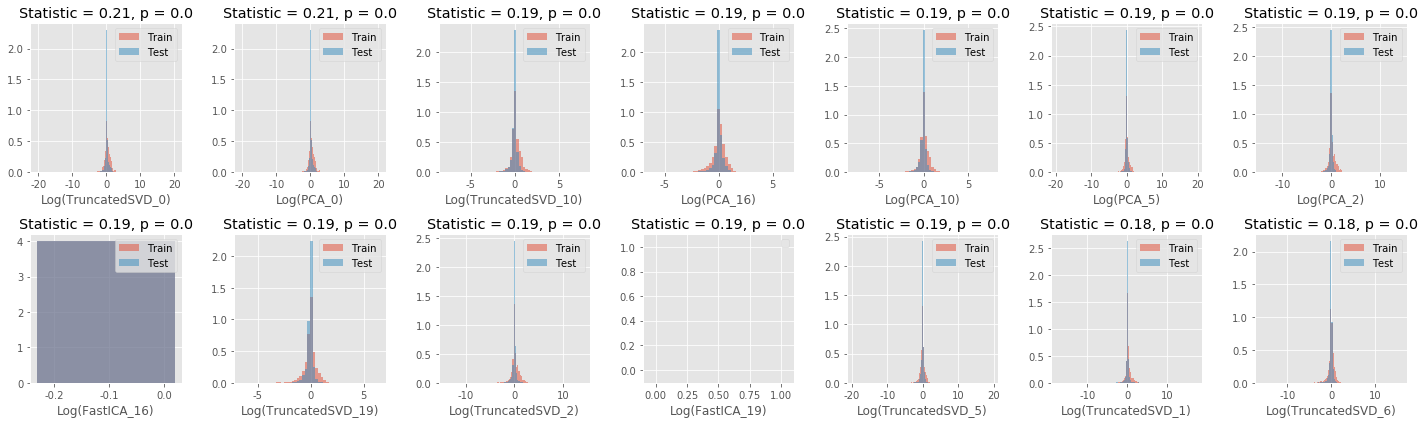

>> Dropping 74 features based on KS tests
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63      4459
         1.0       0.62      0.55      0.59      4459

    accuracy                           0.61      8918
   macro avg       0.61      0.61      0.61      8918
weighted avg       0.61      0.61      0.61      8918



In [22]:
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(
    components_df.iloc[train_idx], components_df.iloc[test_idx],
    threshold=0.1
)

# Run classification on total raw data
print(f">> Dropping {len(diff_df)} features based on KS tests")
test_prediction(
    components_df.drop(diff_df.feature.values, axis=1)
)